## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
# assert timm==0.4.5

# check whether run in Colab
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
#     !git clone https://github.com/facebookresearch/mae.git
#     sys.path.append('./mae')
# else:
#     sys.path.append('..')
import models_mae

### Define utils

In [3]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def find_all_patches_index(image, patch_size=16):
    _, height, width = image.shape
    num_patches_y = height // patch_size
    num_patches_x = width // patch_size
    patches = []
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            y_start = i * patch_size
            y_end = y_start + patch_size
            x_start = j * patch_size
            x_end = x_start + patch_size
            patch = image[:, y_start:y_end, x_start:x_end]
            patches.append(patch)

    black_patch_indices = []
    for idx, patch in enumerate(patches):
        if (patch == 0).all():
            black_patch_indices.append(idx)

    black_index = set(black_patch_indices)
    all_patched = set(np.arange(0, num_patches_y*num_patches_x))
    nonblack_index = list(all_patched - black_index)
    all_index = (nonblack_index, list(black_index))
    return all_index

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img_root, model, mask_ratio=0.75):
    img = Image.open(img_root)
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    image = img.transpose(2,0,1)
    all_index = find_all_patches_index(image)
    
    assert img.shape == (224, 224, 3)
    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std

    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio, all_index=all_index)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [48, 48]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], f"reconstruction, loss{loss:.2f}")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

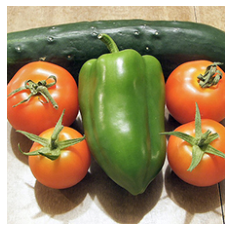

In [4]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)

# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/CroppedImg/IMG_2216_2.jpg"
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/CroppedImg/IMG_2215_3.jpg"
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/MaskedImg/IMG_2215_5.jpg"
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/MaskedImg/IMG_2217_1.jpg"
# img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/MaskedImg/IMG_2215_4.jpg"
# img = Image.open(img_root)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [5]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


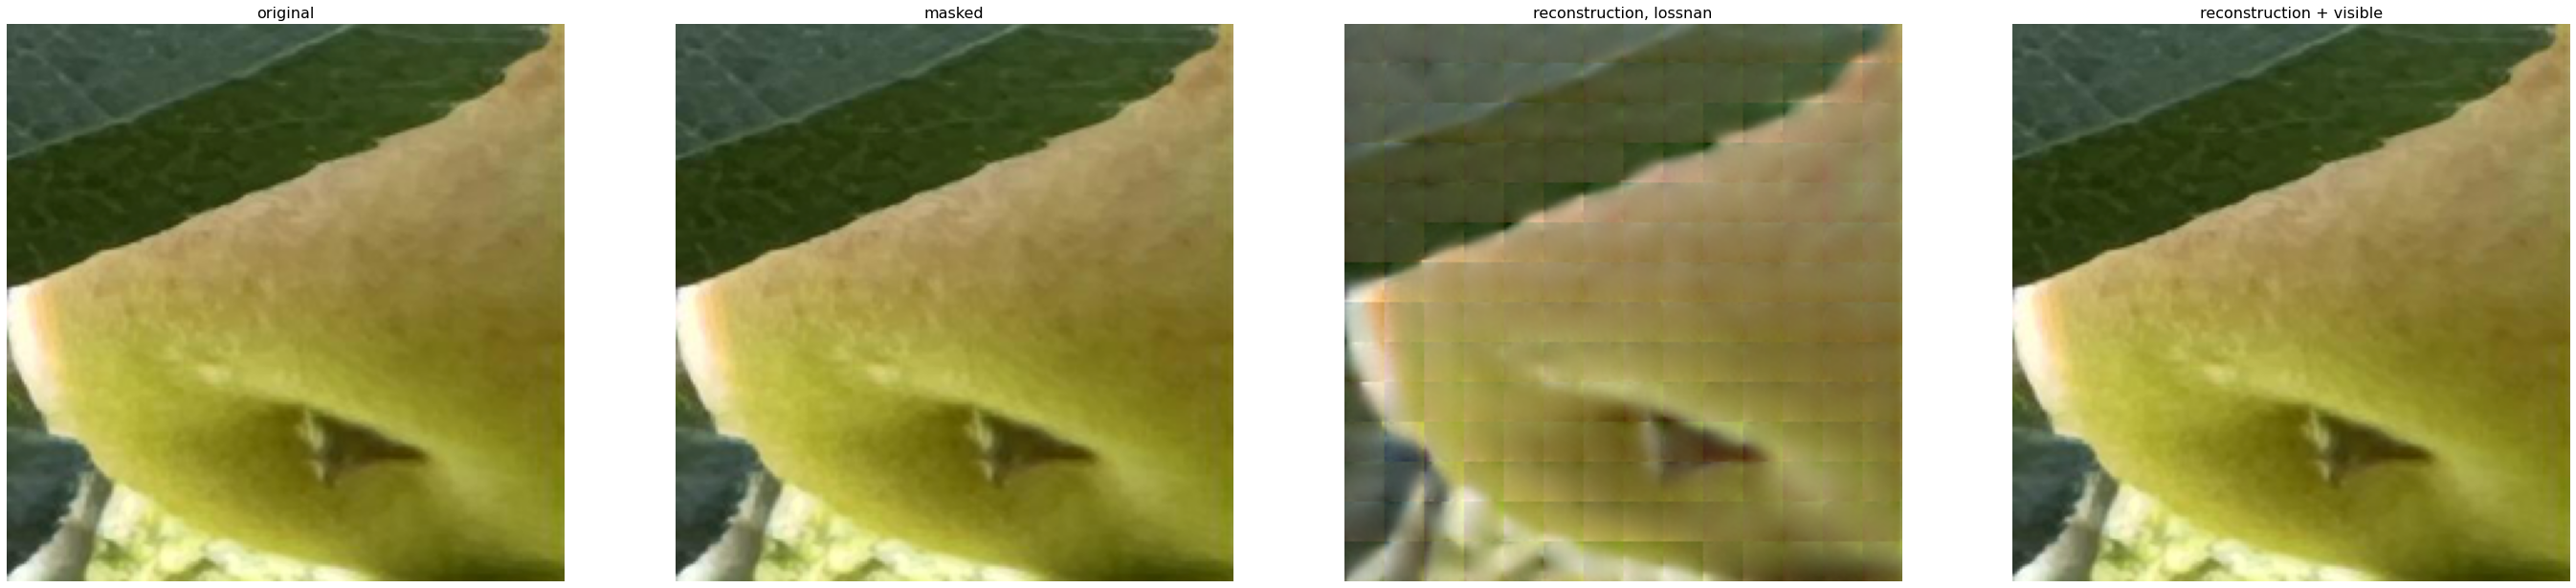

In [25]:
import random
# make random mask reproducible (comment out to make it change)
torch.manual_seed(30)
img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/CroppedImg/"
img_list = os.listdir(img_root)
idx=random.randint(0,len(img_list))
img_path = img_root + img_list[idx]
# img_path = requests.get(img_url, stream=True).raw
print('MAE with pixel reconstruction:')
run_one_image(img_path, model_mae, mask_ratio=0.7)

### Load another pre-trained MAE model

In [6]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.



<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


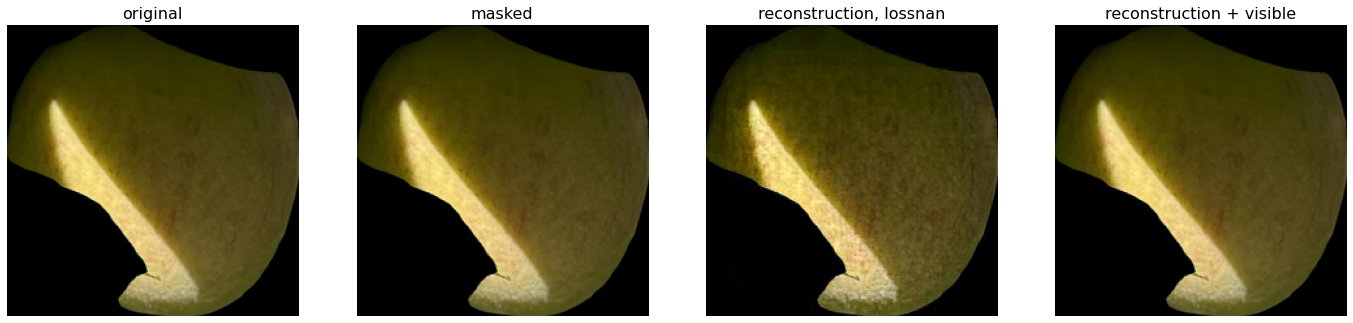

In [20]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

In [43]:
import torch

def extract_patches(image, patch_size=16):
    _, height, width = image.shape
    num_patches_y = height // patch_size
    num_patches_x = width // patch_size
    patches = []
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            y_start = i * patch_size
            y_end = y_start + patch_size
            x_start = j * patch_size
            x_end = x_start + patch_size
            patch = image[:, y_start:y_end, x_start:x_end]
            patches.append(patch)
    return patches

def find_black_patches(patches):
    black_patch_indices = []
    for idx, patch in enumerate(patches):
        if (patch == 0).all():
            black_patch_indices.append(idx)
    return black_patch_indices


img_root = "/home/ziangzhao/Projects/FoundaModel/dataset/AppleDataset/MaskedImg/IMG_2215_4.jpg"
img = Image.open(img_root)
img = img.resize((224, 224))
img = np.array(img) / 255.
image = img.transpose(2,0,1)
# image = torch.zeros(3, 224, 224)  # 创建一个全黑的示例图片
# # 可以在image上设置一些patch为非全黑，用于测试
# image[:, 0:16, 0:16] = 1  # 设置第一个patch为非全黑

patches = extract_patches(image, patch_size=16)
black_index = set(find_black_patches(patches))
all_patched = set(np.arange(0,196))
nonblack_index = list(all_patched - black_index)
all_index = (nonblack_index, black_index)
len(nonblack_index), len(black_index), len(all_index)
# nonblack_index
# all_pached
# non_black_patches = [195-b for b in black_patches]
# print(black_patches), print(non_black_patches)



(156, 40, 2)